In [1]:
import os
import numpy as np
from astropy.io import ascii
from scipy.interpolate import interp1d
import xidplus
temps=os.listdir('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/')

In [2]:
temps

['Blue_SF_glx.norm_LIR',
 'BroadFIR_SF_glx.norm_LIR',
 'Cold_glx.norm_LIR',
 'Elliptical.norm_LIR',
 'Ly_break.norm_LIR',
 'MIR_powlaw_SF_glx.norm_LIR',
 'MIRex_SF_glx.norm_LIR',
 'Mod_SF_glx.norm_LIR',
 'Obs_SF_glx.norm_LIR',
 'PAH_DF_glx.norm_LIR',
 'Red_SF_glx_1.norm_LIR',
 'Red_SF_glx_2.norm_LIR',
 'Secular_glx.norm_LIR',
 'SF_glx_1.norm_LIR',
 'SF_glx_2.norm_LIR',
 'SF_Type1_AGN_1.norm_LIR',
 'SF_Type1_AGN_2.norm_LIR',
 'SF_Type1_AGN_3.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'SF_Type2_AGN_1.norm_LIR',
 'SF_Type2_AGN_2.norm_LIR',
 'SF_Type2_AGN_3.norm_LIR',
 'Si_break.norm_LIR',
 'Spiral.norm_LIR',
 'Torus.norm_LIR',
 'Type1_AGN_1.norm_LIR',
 'Type2_AGN_1.norm_LIR',
 'Type2_AGN_2.norm_LIR',
 'Warm_SF_glx.norm_LIR',
 'WeakPAH_SF_glx_1.norm_LIR',
 'WeakPAH_SF_glx_2.norm_LIR',
 'Young_SF_glx.norm_LIR']

Generate Redshift Grid and convert to denominator for flux conversion (e.g. $4 \pi D_l^2)$

In [3]:
red=np.arange(0,8,0.001)
red[0]=0.000001
from astropy.cosmology import Planck13
import astropy.units as u
div=(4.0*np.pi * np.square(Planck13.luminosity_distance(red).cgs))
div=div.value

In [4]:
len(red)

8000

Get appropriate filters

In [5]:
from xidplus import filters
filter=filters.FilterFile(file=xidplus.__path__[0]+'/../test_files/filters.res')

In [6]:
filter.names()

    1 Koo-Kron U+ filter (Koo's thesis) - 0001
    2 Koo-Kron J+ filter (Koo's thesis) - 0002
    3 Koo-Kron F+ filter (Koo's thesis) - 0003
    4 Koo-Kron N+ filter (Koo's thesis) - 0004
    5 Koo-Kron R band (=127+RG610, data from Koo, Durham) - 0005
    6 Couch and Newell (80) BJ (photographic) filter - 0006
    7 Couch and Newell (80) RF (photographic) filter - 0007
    8 Koo-Kron U+ filter (Bruzual's thesis) - 0008
    9 Koo-Kron J+ filter (Bruzual's thesis) - 0009
   10 Koo-Kron F+ filter (Bruzual's thesis) - 0010
   11 Koo-Kron N+ filter (Bruzual's thesis) - 0011
   12 Buser's U filter - 0012
   13 Buser's B2 filter - 0013
   14 Buser's B3 filter - 0014
   15 Buser's V filter - 0015
   16 Matthews and Sandage U filter - 0016
   17 Matthews and Sandage B filter - 0017
   18 Matthews and Sandage V filter - 0018
   19 Sandage and Smith B filter - 0019
   20 Sandage and Smith V filter - 0020
   21 Sandage and Smith R filter - 0021
   22 ST-UV14 filter - 0022
   23 ST-UV17 filter - 0

In [7]:

SPIRE_250=filter.filters[215]
SPIRE_350=filter.filters[216]
SPIRE_500=filter.filters[217]
MIPS_24=filter.filters[201]
PACS_100=filter.filters[250]
PACS_160=filter.filters[251]

bands=[SPIRE_250,SPIRE_350,SPIRE_500,MIPS_24,PACS_100,PACS_160]
eff_lam=[250.0,350.0,500.0,24.0, 100.0,160.0]

In [8]:
for b in bands:
    print(b.name)

SPIRE 250 micron - 0216
SPIRE 350 micron - 0217
SPIRE 500 micron - 0218
Spitzer MIPS CH1 (24 microns) - 0202
PACS 100 Instrument Simulator as of Herschel Launch - 0251
PACS 160 Instrument Simulator as of Herschel Launch - 0252


In [9]:
import pandas as pd
template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[0])
df=pd.DataFrame(template['col1'].data/1E4,columns=['wave'])
print(template['col1'].data/1E4)
SEDs=np.empty((len(temps),len(bands),red.size))
for i in range(0,len(temps)):
    template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[i])
    df[temps[i]]=1E30*3.826E33*template['col2']*((template['col1']/1E4)**2)/3E14
    
    flux=template['col2']*((template['col1']/1E4)**2)/3E14
    wave=template['col1']/1E4
    ind=(wave > 8) & (wave < 1E3)
    print(np.trapz(template['col2'][ind],x=wave[ind]*1E4))
    print(np.trapz(flux[ind][::-1],x=3E14/(wave[ind][::-1])))
    for z in range(0,red.size):
        sed=interp1d((red[z]+1.0)*wave, flux)
        for b in range(0,len(bands)):
            SEDs[i,b,z]=1E30*3.826E33*(1.0+red[z])*filters.fnu_filt(sed(bands[b].wavelength/1E4),3E8/(bands[b].wavelength/1E10),bands[b].transmission,3E8/(eff_lam[b]*1E-6),sed(eff_lam[b]))/div[z]
        

[  9.09999900e-03   9.40000000e-03   9.59999900e-03 ...,   1.92899989e+03
   1.93899920e+03   1.94899898e+03]
0.999999999975
9.99948820898e-05
0.99999999803
9.99972496544e-05
1.00000000022
9.99986398139e-05
0.999999998638
9.99981291963e-05
0.99999999959
9.99980481754e-05
0.999999998941
9.9994351254e-05
0.999999999473
9.99945356128e-05
0.999999998487
9.99985287929e-05
0.999999999224
9.99924626717e-05
1.00000000252
9.99942862546e-05
0.999999999244
9.99934616998e-05
0.999999998734
9.99978906062e-05
0.999999998627
9.99975982287e-05
1.00000000001
9.99978318847e-05
1.00000000032
9.99982075976e-05
0.999999999528
9.99931710553e-05
0.999999998064
9.99973969093e-05
0.999999998802
9.99981096303e-05
0.999999998357
9.99934745402e-05
1.0000000015
9.99946455636e-05
1.00000000065
9.99976450848e-05
0.999999999482
9.9997162806e-05
0.999999997908
9.99972721906e-05
1.00000000223
9.99944923657e-05
1.00000000041
9.99917794923e-05
1.00000000008
9.99882557381e-05
1.00000000182
9.99945487078e-05
0.99999999873


## Read in Michael's templates

Individual infrared templates are given in 

http://astro.imperial.ac.uk/public/mrr/swirephotzcat/templates/cirrus.dat
http://astro.imperial.ac.uk/public/mrr/swirephotzcat/templates/M82.dat
http://astro.imperial.ac.uk/public/mrr/swirephotzcat/templates/A220.dat
 
as pairs of numbers log10 lambda(mu), log vu S(nu),

and in 
http://astro.imperial.ac.uk/public/mrr/swirephotzcat/templates/dusttor.dat

as pairs of numbers log10 lambda(mu), vu S(nu) [first two columns only].

In [10]:
from astropy.table import Table


In [11]:
cirrus=Table.read('/Users/pdh21/astrodata/SEDs/MRR/cirrus.dat', format='ascii')
dusttor=Table.read('/Users/pdh21/astrodata/SEDs/MRR/dusttor.dat', format='ascii')
M82=Table.read('/Users/pdh21/astrodata/SEDs/MRR/M82.dat', format='ascii')
A220=Table.read('/Users/pdh21/astrodata/SEDs/MRR/A220.dat', format='ascii')
dusttor['col2']=np.log(dusttor['col2'])
cirrus.add_row([0.1,-15])
M82.add_row([0.1,-10])

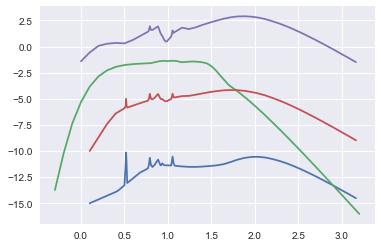

In [12]:
import pylab as plt
%matplotlib inline
plt.plot(cirrus['col1'],cirrus['col2'])
plt.plot(dusttor['col1'],dusttor['col2'])
plt.plot(M82['col1'],M82['col2'])
plt.plot(A220['col1'],A220['col2'])


In [13]:
import pandas as pd
df_comb=pd.DataFrame(np.power(10.0,cirrus['col1'].data),columns=['wave'])
MRR_temps=[cirrus, A220,M82,dusttor]
SEDs_comb=np.empty((len(MRR_temps),len(bands),red.size))

for i in range(0,len(MRR_temps)):
    

    flux=np.power(10.0,MRR_temps[i]['col2'])/(3.0E14/np.power(10.0,MRR_temps[i]['col1']))
    
    wave=np.power(10.0,MRR_temps[i]['col1'])
    ind=(wave > 8) & (wave < 1E3)
    flux=1E-4*flux/np.trapz(flux[ind],x=3E14/wave[ind])
    print(np.trapz(flux[ind],x=3E14/wave[ind]))
    sed=interp1d(wave, 1E30*3.826E33*flux)
    df_comb[str(i)]=sed(df_comb['wave'])
    
    for z in range(0,red.size):
        sed=interp1d((red[z]+1.0)*wave, flux)
        for b in range(0,len(bands)):
            try:
                SEDs_comb[i,b,z]=1E30*3.826E33*(1.0+red[z])*filters.fnu_filt(sed(bands[b].wavelength/1E4),3E8/(bands[b].wavelength/1E10),bands[b].transmission,3E8/(eff_lam[b]*1E-6),sed(eff_lam[b]))/div[z]
            except ValueError:
                print(red[z],bands[b].name)

0.0001
0.0001
0.0001
0.0001


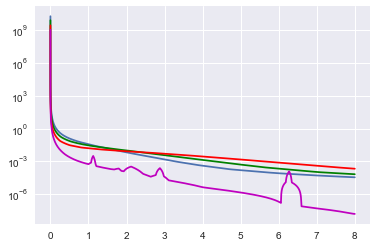

In [14]:
import pylab as plt
%matplotlib inline
plt.semilogy(red,SEDs_comb[0,0,:]*np.power(10.0,9))
plt.semilogy(red,SEDs_comb[0,1,:]*np.power(10.0,9),c='g')
plt.semilogy(red,SEDs_comb[0,2,:]*np.power(10.0,9),c='r')
plt.semilogy(red,SEDs_comb[0,3,:]*np.power(10.0,9),c='m')



In [15]:
div_test=(4.0*np.pi * np.square(Planck13.luminosity_distance(0.001).cgs))
div_test=div_test.value


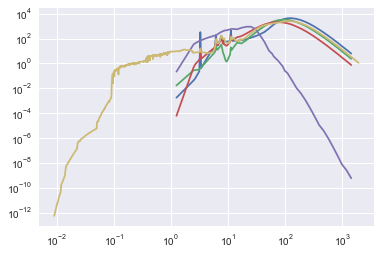

In [16]:
plt.loglog(df_comb['wave'],np.power(10.0,8)*(1.0+0.001)*df_comb['0']/div_test)
plt.loglog(df_comb['wave'],np.power(10.0,8)*(1.0+0.001)*df_comb['1']/div_test)
plt.loglog(df_comb['wave'],np.power(10.0,8)*(1.0+0.001)*df_comb['2']/div_test)
plt.loglog(df_comb['wave'],np.power(10.0,8)*(1.0+0.001)*df_comb['3']/div_test)


plt.loglog(df['wave'],np.power(10.0,8)*(1.0+0.001)*df[temps[0]]/div_test)


In [18]:
df_comb

wave             0             1             2             3
0   1450.106836  1.468242e+44  5.529822e+43  1.761320e+43  1.372804e+34
1   1200.107086  2.976032e+44  1.129513e+44  3.620497e+43  6.056712e+34
2   1000.000000  5.700954e+44  2.175560e+44  7.035876e+43  1.740812e+35
3    831.955314  1.122917e+45  4.327839e+44  1.413508e+44  9.295101e+35
4    691.990289  2.110608e+45  8.205426e+44  2.716678e+44  4.729118e+36
5    575.042575  3.977567e+45  1.570801e+45  5.281633e+44  2.223205e+37
6    478.960832  7.157437e+45  2.874161e+45  9.859575e+44  8.889300e+37
7    398.015514  1.260310e+46  5.177155e+45  1.819945e+45  2.591120e+38
8    330.978665  2.140314e+46  9.078020e+45  3.287216e+45  1.298570e+39
9    274.979299  3.443718e+46  1.523601e+46  5.723190e+45  6.115512e+39
10   228.981291  5.189644e+46  2.423936e+46  9.523535e+45  2.586673e+40
11   190.989724  7.179886e+46  3.599077e+46  1.490041e+46  9.061064e+40
12   158.019251  9.071259e+46  5.039543e+46  2.231558e+46  2.655488e+41
13   132.010963  1.033469e+47  6.582504e+46  3.145489e+46  1.085482e+42
14   109.999320  1.004009e+47  7.635388e+46  4.027896e+46  4.111664e+42
15   100.000000  9.212077e+46  7.798142e+46  4.372081e+46  5.894249e+42
16    91.201084  8.160703e+46  7.814859e+46  4.681642e+46  1.390562e+43
17    75.892699  5.546354e+46  7.147286e+46  5.000900e+46  3.903423e+43
18    63.095734  3.092200e+46  5.663712e+46  4.795437e+46  9.113723e+43
19    60.006735  2.568547e+46  5.185148e+46  4.655949e+46  1.382843e+44
20    52.504920  1.526819e+46  3.898083e+46  4.136454e+46  2.527836e+44
21    43.701868  7.986703e+45  2.368379e+46  3.218016e+46  1.298396e+45
22    36.298610  5.091052e+45  1.307709e+46  2.272209e+46  4.673905e+45
23    30.200213  3.652057e+45  6.988133e+45  1.496333e+46  1.460741e+46
24    24.998273  2.686814e+45  3.522501e+45  9.378820e+45  2.154686e+46
25    20.897773  2.086592e+45  1.704673e+45  5.880418e+45  2.108957e+46
26    17.398027  1.750079e+45  9.682804e+44  3.783452e+45  1.734996e+46
27    14.501068  1.604270e+45  1.106678e+45  2.995768e+45  1.317103e+46
28    12.001071  1.540734e+45  3.505509e+44  1.854890e+45  1.419808e+46
29    11.601122  2.439819e+45  2.792294e+44  1.881561e+45  1.393493e+46
30    11.301081  1.103818e+46  4.621374e+44  3.928242e+45  1.373751e+46
31    10.999932  2.434656e+45  1.525040e+44  1.465204e+45  1.326228e+46
32    10.899084  1.475019e+45  1.186728e+44  1.199246e+45  1.306905e+46
33     9.709570  1.370243e+45  3.578171e+43  6.619089e+44  1.117062e+46
34     9.399397  1.329161e+45  3.351901e+43  6.185548e+44  1.098289e+46
35     8.990834  1.333821e+45  4.999783e+43  6.962548e+44  1.073561e+46
36     8.590135  1.896783e+45  1.071029e+44  9.306968e+44  1.004993e+46
37     8.390735  1.223088e+45  1.342552e+44  8.826290e+44  9.655134e+45
38     8.199738  1.177952e+45  1.897366e+44  9.410186e+44  9.276975e+45
39     7.689534  3.816344e+45  7.737687e+44  2.560874e+45  8.105200e+45
40     7.000032  1.065829e+45  4.258250e+44  9.635587e+44  6.300909e+45
41     6.609978  6.471539e+44  3.015790e+44  6.672340e+44  5.280214e+45
42     6.369422  9.788532e+44  3.014541e+44  7.481319e+44  4.650726e+45
43     6.190133  4.646517e+45  6.538997e+44  2.133183e+45  4.384508e+45
44     6.029760  8.760876e+44  2.419475e+44  6.375411e+44  4.237337e+45
45     5.850595  4.065440e+44  1.763361e+44  4.359013e+44  4.072922e+45
46     4.799544  1.408016e+44  6.383082e+43  2.109882e+44  3.106764e+45
47     3.400165  9.718238e+42  1.137538e+43  5.553007e+43  1.754646e+45
48     3.339566  7.890373e+44  1.038773e+43  8.542957e+43  1.692606e+45
49     3.299894  7.783547e+45  9.741155e+42  3.702697e+44  1.651991e+45
50     3.269565  7.822896e+44  9.246852e+42  8.030234e+43  1.620941e+45
51     3.160094  5.448006e+42  7.495430e+42  4.481982e+43  1.508720e+45
52     3.069729  4.346178e+42  7.377868e+42  4.016689e+43  1.410144e+45
53     2.690296  1.503376e+42  6.884240e+42  2.062980e+43  9.962324e+44
54     2.511886  1.013882e+42  6.652136e+42  1.1443

In [17]:
np.save('SED_comb', SEDs_comb)

In [142]:
df_comb.to_pickle('SEDS_IR_comb_full.pkl')

In [143]:
ls

SEDS_Herschel_full.pkl
SEDS_IR_comb_full.pkl
SEDS_IR_full.pkl
SEDS_full.pkl
SED_Herschel.npy
SED_IR.npy
SED_IR_sig.npy
SED_SPIRE_PACS100.npy
SED_comb.npy
SED_prior_model.ipynb
SED_prior_model_v2.ipynb
XID+SPIRE.pkl
XID+example_run_script.ipynb
XID+example_run_script_SED.ipynb
XID+posterior_analysis_validation.ipynb
foo.html
log10_SED_IR_sig.npy
test.fits
test.pkl


In [15]:
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot, column
from bokeh.plotting import figure
from bokeh.io import push_notebook
output_notebook()
from bokeh.models import HoverTool, Range1d

from bokeh.models import ColumnDataSource, DataSource
from bokeh.models import CustomJS, ColumnDataSource, Slider


Loading BokehJS ...

In [22]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()


plot_options = dict(width=250, plot_height=250)

LIR=12

# create a new plot
source = ColumnDataSource(
        data=dict(
            x=SEDs[:,0,200]*10.0**LIR,
            y=SEDs[:,1,200]*10.0**LIR,
            z=SEDs[:,2,200]*10.0**LIR,
            width=(SEDs[:,0,200]*10.0**LIR)/5.0,
            height=(SEDs[:,1,200]*10.0**LIR)/5.0,
            depth=(SEDs[:,2,200]*10.0**LIR)/5.0,
            desc=temps,
        )
    )

hover1 = HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    )
hover2 = HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    )
hover3 = HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    )
s1 = figure(**plot_options,tools=[hover1, 'pan', 'wheel_zoom'])
s1.circle('x', 'y', size=10, source=source,color="navy", alpha=0.0)

s1.ellipse('x', 'y', height='height',width='width', source=source,color="navy", alpha=0.2)
s1.yaxis.axis_label = r'350'

# create a new plot and share both ranges
s2 = figure(x_range=s1.x_range, **plot_options,tools=[hover2, 'pan', 'wheel_zoom'])
s2.circle('x', 'z', size=10, source=source,color="navy", alpha=0.0)

s2.ellipse('x', 'z',height='depth',width='width' , source=source,color="navy", alpha=0.2)
s2.yaxis.axis_label = r'500'
s2.xaxis.axis_label = r'250'


# create a new plot and share only one range
s3 = figure(x_range=s1.y_range,y_range=s2.y_range, **plot_options,tools=[hover3, 'pan', 'wheel_zoom'])
s3.circle('y', 'z', size=10, source=source,color="navy", alpha=0.0)
s3.ellipse('y', 'z',height='depth',width='height', source=source,color="navy", alpha=0.2)
s3.xaxis.axis_label = r'350'

p = gridplot([[s1,],[s2, s3]])

def update(LIR=12,z=red[200]):
    ind=np.long(z*100)
    print(ind)
    source.data['x']=SEDs[:,0,ind]*10.0**LIR
    source.data['y']=SEDs[:,1,ind]*10.0**LIR
    source.data['z']=SEDs[:,2,ind]*10.0**LIR
    source.data['width']=np.full(SEDs.shape[0],np.std(SEDs[:,0,ind]*10.0**LIR))
    source.data['depth']=np.full(SEDs.shape[0],np.std(SEDs[:,1,ind]*10.0**LIR))
    source.data['height']=np.full(SEDs.shape[0],np.std(SEDs[:,2,ind]*10.0**LIR))
    push_notebook()


show(p, notebook_handle=True)
interact(update,LIR=(8,14,0.01),z=(red[0],red[-1],0.01))








Loading BokehJS ...

<function __main__.update>

In [32]:
samps=np.empty((6,2000))
for i in range(0,2000):
    samps[:,i]=np.sum(SEDs_comb[:,:,np.random.randint(len(red))].T*10.0**np.random.uniform(low=np.array([5,5,5,5]),high=np.array([12,12,12,12]))
,axis=1)

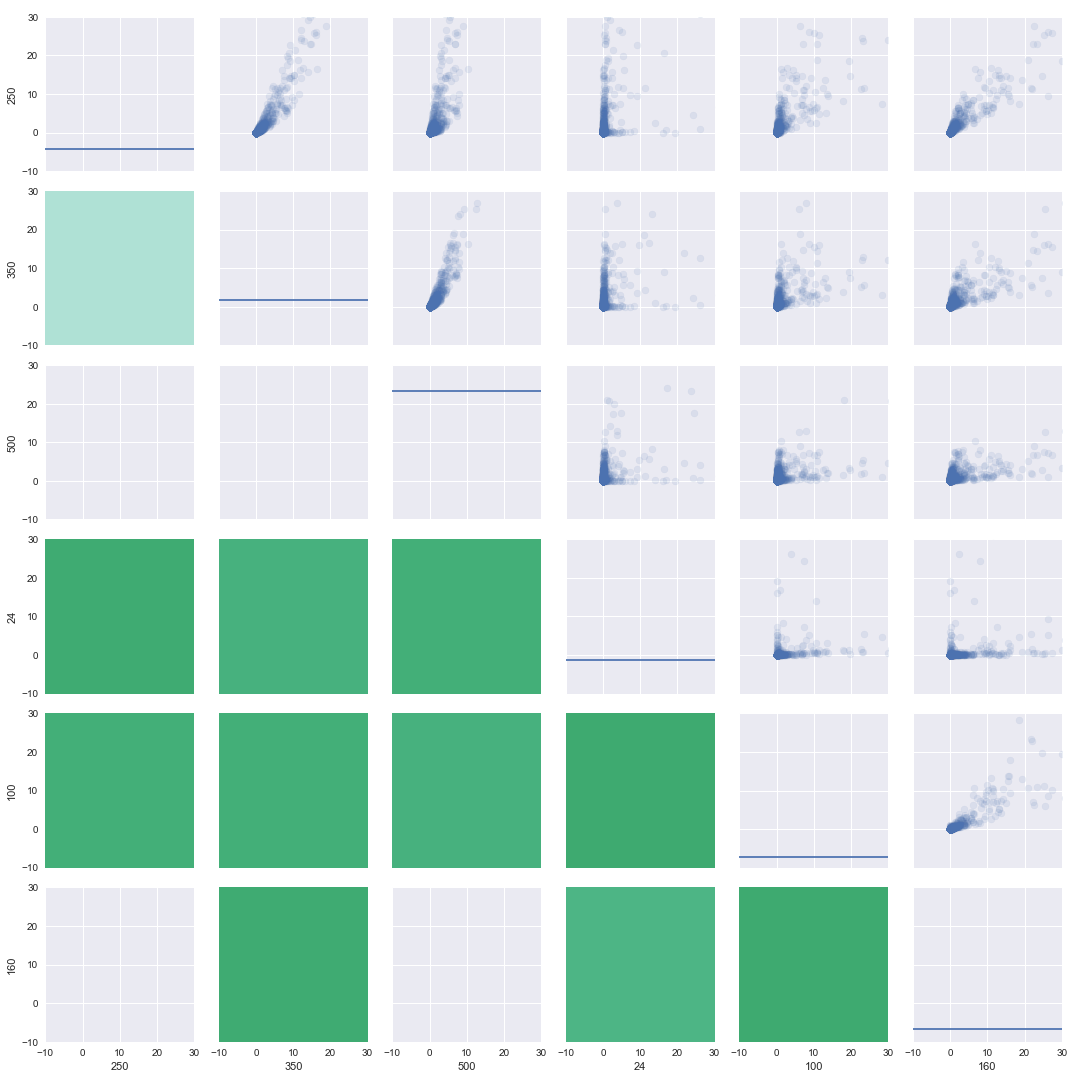

In [38]:
df=pd.DataFrame(samps.T,columns=['250','350','500','24', '100', '160'])
import seaborn as sns
import pylab as plt
%matplotlib inline
g=sns.PairGrid(df)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot,n_levels=20, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, alpha=0.1)
for i in range(0,6):
    for j in range(0,6):
        g.axes[i,j].set_ylim(-10,30)
        g.axes[i,j].set_xlim(-10,30)

In [33]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()


plot_options = dict(width=250, plot_height=250)

LIR=np.array([12,12,12,12])

# create a new plot
source = ColumnDataSource(
        data=dict(
            s250=SEDs_comb[:,0,200]*10.0**LIR,
            s350=SEDs_comb[:,1,200]*10.0**LIR,
            s500=SEDs_comb[:,2,200]*10.0**LIR,
            s24=SEDs_comb[:,3,200]*10.0**LIR,
            s100=SEDs_comb[:,4,200]*10.0**LIR,
            s160=SEDs_comb[:,5,200]*10.0**LIR,
        )
    )



  
s0_0 = figure(**plot_options,tools=[ 'pan', 'wheel_zoom'])
s0_0.circle('s100', 's160', size=10, source=source,color="navy", alpha=0.2)

s0_0.yaxis.axis_label = r'160'

# create a new plot and share both ranges
s0_1 = figure(x_range=s0_0.x_range, **plot_options,tools=[ 'pan', 'wheel_zoom'])
s0_1.circle('s100', 's250', size=10, source=source,color="navy", alpha=0.2)

s0_1.yaxis.axis_label = r'250'

s0_2 = figure(x_range=s0_0.x_range, **plot_options,tools=[ 'pan', 'wheel_zoom'])
s0_2.circle('s100', 's350', size=10, source=source,color="navy", alpha=0.0)

s0_2.yaxis.axis_label = r'350'

s0_3 = figure(x_range=s0_0.x_range, **plot_options,tools=['pan', 'wheel_zoom'])
s0_3.circle('s100', 's500', size=10, source=source,color="navy", alpha=0.2)

s0_3.yaxis.axis_label = r'500'
s0_3.xaxis.axis_label = r'100'

s1_1 = figure(x_range=s0_0.y_range,y_range=s0_1.y_range, **plot_options,tools=['pan', 'wheel_zoom'])
s1_1.circle('s160', 's250', size=10, source=source,color="navy", alpha=0.2)

s1_1.yaxis.axis_label = r'250'

s1_2 = figure(x_range=s0_0.y_range,y_range=s0_2.y_range, **plot_options,tools=['pan', 'wheel_zoom'])
s1_2.circle('s160', 's350', size=10, source=source,color="navy", alpha=0.0)

s1_2.yaxis.axis_label = r'350'

s1_3 = figure(x_range=s0_0.y_range,y_range=s0_3.y_range, **plot_options,tools=['pan', 'wheel_zoom'])
s1_3.circle('s160', 's500', size=10, source=source,color="navy", alpha=0.0)

s1_3.yaxis.axis_label = r'500'
s1_3.xaxis.axis_label = r'160'

s2_2 = figure(x_range=s0_1.y_range,y_range=s0_2.y_range, **plot_options,tools=['pan', 'wheel_zoom'])
s2_2.circle('s250', 's350', size=10, source=source,color="navy", alpha=0.0)

s2_2.yaxis.axis_label = r'350'

s2_3 = figure(x_range=s0_1.y_range,y_range=s0_3.y_range, **plot_options,tools=['pan', 'wheel_zoom'])
s2_3.circle('s250', 's500', size=10, source=source,color="navy", alpha=0.0)

s2_3.yaxis.axis_label = r'500'
s2_3.xaxis.axis_label = r'250'

s3_3 = figure(x_range=s0_2.y_range,y_range=s0_3.y_range, **plot_options,tools=['pan', 'wheel_zoom'])
s3_3.circle('s350', 's500', size=10, source=source,color="navy", alpha=0.0)

s3_3.yaxis.axis_label = r'500'
s3_3.xaxis.axis_label = r'350'



p = gridplot([[s0_0,],[s0_1,s1_1,],[s0_2,s1_2,s2_2,],[s0_3,s1_3,s2_3,s3_3]])

def update(LIR_1=12,LIR_2=12,LIR_3=12,LIR_4=12,z=red[200]):
    LIR=np.array([LIR_1,LIR_2,LIR_3,LIR_4])
    ind=np.long(z*100)
    print(ind)
    source.data['s250']=SEDs_comb[:,0,ind]*10.0**LIR
    source.data['s350']=SEDs_comb[:,1,ind]*10.0**LIR
    source.data['s500']=SEDs_comb[:,2,ind]*10.0**LIR
    source.data['s100']=SEDs_comb[:,3,ind]*10.0**LIR
    source.data['s160']=SEDs_comb[:,4,ind]*10.0**LIR
    
    
    push_notebook()


show(p, notebook_handle=True)
interact(update,LIR_1=(8,14,0.01),LIR_2=(8,14,0.01),LIR_3=(8,14,0.01),LIR_4=(8,14,0.01),z=(red[0],red[-1],0.01))








Loading BokehJS ...

<function __main__.update>

In [84]:
####log 10 version
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()


plot_options = dict(width=250, plot_height=250)

LIR=12

# create a new plot
source = ColumnDataSource(
        data=dict(
            s250=np.log10(SEDs[:,0,200]*10.0**LIR),
            s350=np.log10(SEDs[:,1,200]*10.0**LIR),
            s500=np.log10(SEDs[:,2,200]*10.0**LIR),
            s100=np.log10(SEDs[:,3,200]*10.0**LIR),
            s160=np.log10(SEDs[:,4,200]*10.0**LIR),
            s250_sig=np.full(SEDs.shape[0],sig[0,200]),
            s350_sig=np.full(SEDs.shape[0],sig[1,200]),
            s500_sig=np.full(SEDs.shape[0],sig[2,200]),
            s100_sig=np.full(SEDs.shape[0],sig[3,200]),
            s160_sig=np.full(SEDs.shape[0],sig[4,200]),
            desc=temps,
        )
    )


hover=[]
for i in range(0,10):
    hover.append(HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    ))

  
s0_0 = figure(**plot_options,tools=[hover[0], 'pan', 'wheel_zoom'])
s0_0.circle('s100', 's160', size=10, source=source,color="navy", alpha=0.0)

s0_0.ellipse('s100', 's160', height='s160_sig',width='s100_sig', source=source,color="navy", alpha=0.2)
s0_0.yaxis.axis_label = r'160'

# create a new plot and share both ranges
s0_1 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[1], 'pan', 'wheel_zoom'])
s0_1.circle('s100', 's250', size=10, source=source,color="navy", alpha=0.0)

s0_1.ellipse('s100', 's250',height='s250_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_1.yaxis.axis_label = r'250'

s0_2 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[2], 'pan', 'wheel_zoom'])
s0_2.circle('s100', 's350', size=10, source=source,color="navy", alpha=0.0)

s0_2.ellipse('s100', 's350',height='s350_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_2.yaxis.axis_label = r'350'

s0_3 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[3], 'pan', 'wheel_zoom'])
s0_3.circle('s100', 's500', size=10, source=source,color="navy", alpha=0.0)

s0_3.ellipse('s100', 's500',height='s500_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_3.yaxis.axis_label = r'500'
s0_3.xaxis.axis_label = r'100'

s1_1 = figure(x_range=s0_0.y_range,y_range=s0_1.y_range, **plot_options,tools=[hover[4], 'pan', 'wheel_zoom'])
s1_1.circle('s160', 's250', size=10, source=source,color="navy", alpha=0.0)

s1_1.ellipse('s160', 's250',height='s250_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_1.yaxis.axis_label = r'250'

s1_2 = figure(x_range=s0_0.y_range,y_range=s0_2.y_range, **plot_options,tools=[hover[5], 'pan', 'wheel_zoom'])
s1_2.circle('s160', 's350', size=10, source=source,color="navy", alpha=0.0)

s1_2.ellipse('s160', 's350',height='s350_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_2.yaxis.axis_label = r'350'

s1_3 = figure(x_range=s0_0.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[6], 'pan', 'wheel_zoom'])
s1_3.circle('s160', 's500', size=10, source=source,color="navy", alpha=0.0)

s1_3.ellipse('s160', 's500',height='s500_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_3.yaxis.axis_label = r'500'
s1_3.xaxis.axis_label = r'160'

s2_2 = figure(x_range=s0_1.y_range,y_range=s0_2.y_range, **plot_options,tools=[hover[7], 'pan', 'wheel_zoom'])
s2_2.circle('s250', 's350', size=10, source=source,color="navy", alpha=0.0)

s2_2.ellipse('s250', 's350',height='s350_sig',width='s250_sig' , source=source,color="navy", alpha=0.2)
s2_2.yaxis.axis_label = r'350'

s2_3 = figure(x_range=s0_1.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[8], 'pan', 'wheel_zoom'])
s2_3.circle('s250', 's500', size=10, source=source,color="navy", alpha=0.0)

s2_3.ellipse('s250', 's500',height='s500_sig',width='s250_sig' , source=source,color="navy", alpha=0.2)
s2_3.yaxis.axis_label = r'500'
s2_3.xaxis.axis_label = r'250'

s3_3 = figure(x_range=s0_2.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[9], 'pan', 'wheel_zoom'])
s3_3.circle('s350', 's500', size=10, source=source,color="navy", alpha=0.0)

s3_3.ellipse('s350', 's500',height='s500_sig',width='s350_sig' , source=source,color="navy", alpha=0.2)
s3_3.yaxis.axis_label = r'500'
s3_3.xaxis.axis_label = r'350'



p = gridplot([[s0_0,],[s0_1,s1_1,],[s0_2,s1_2,s2_2,],[s0_3,s1_3,s2_3,s3_3]])

def update(LIR=12,z=red[200]):
    ind=np.long(z*100)
    print(ind)
    source.data['s250']=np.log10(SEDs[:,0,ind]*10.0**LIR)
    source.data['s350']=np.log10(SEDs[:,1,ind]*10.0**LIR)
    source.data['s500']=np.log10(SEDs[:,2,ind]*10.0**LIR)
    source.data['s100']=np.log10(SEDs[:,3,ind]*10.0**LIR)
    source.data['s160']=np.log10(SEDs[:,4,ind]*10.0**LIR)
    
    
    source.data['s250_sig']=np.full(SEDs.shape[0],sig[0,ind])#+LIR
    source.data['s350_sig']=np.full(SEDs.shape[0],sig[1,ind])#+LIR
    source.data['s500_sig']=np.full(SEDs.shape[0],sig[2,ind])#+LIR
    source.data['s100_sig']=np.full(SEDs.shape[0],sig[3,ind])#+LIR
    source.data['s160_sig']=np.full(SEDs.shape[0],sig[4,ind])#+LIR
    push_notebook()


show(p, notebook_handle=True)
interact(update,LIR=(8,14,0.01),z=(red[0],red[-1],0.01))








Loading BokehJS ...

<function __main__.update>

In [77]:
np.full(SEDs.shape[0],sig[0,200])

array([ 0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231])

In [20]:
for t in range(0,SEDs.shape[0]):
    cov=np.zeros((SEDs.shape[1],SEDs.shape[1]))
    for i in range(0,SEDs.shape[1]):
        cov[i,i]=0.3*SEDs[t,i,200]*10.0**LIR
    if t ==0:
        normal=np.random.multivariate_normal(SEDs[t,:,200]*10.0**LIR,cov, 100)
    else:
        normal=np.vstack((normal,np.random.multivariate_normal(SEDs[t,:,200]*10.0**LIR,cov, 100)))

In [81]:
for t in range(0,SEDs.shape[0]):
    cov=np.zeros((SEDs.shape[1],SEDs.shape[1]))
    for i in range(0,SEDs.shape[1]):
        cov[i,i]=0.3*np.std(np.log10(SEDs[:,i,200]*10.0**LIR))
    if t ==0:
        log_normal=np.random.multivariate_normal(np.log10(SEDs[t,:,200]*10.0**LIR),cov, 100)
    else:
        log_normal=np.vstack((log_normal,np.random.multivariate_normal(np.log10(SEDs[t,:,200]*10.0**LIR),cov, 100)))

In [39]:
LIR

12

In [22]:
normal.shape

(3200, 6)

In [82]:
df=pd.DataFrame(normal,columns=['250','350','500','24', '100', '160'])

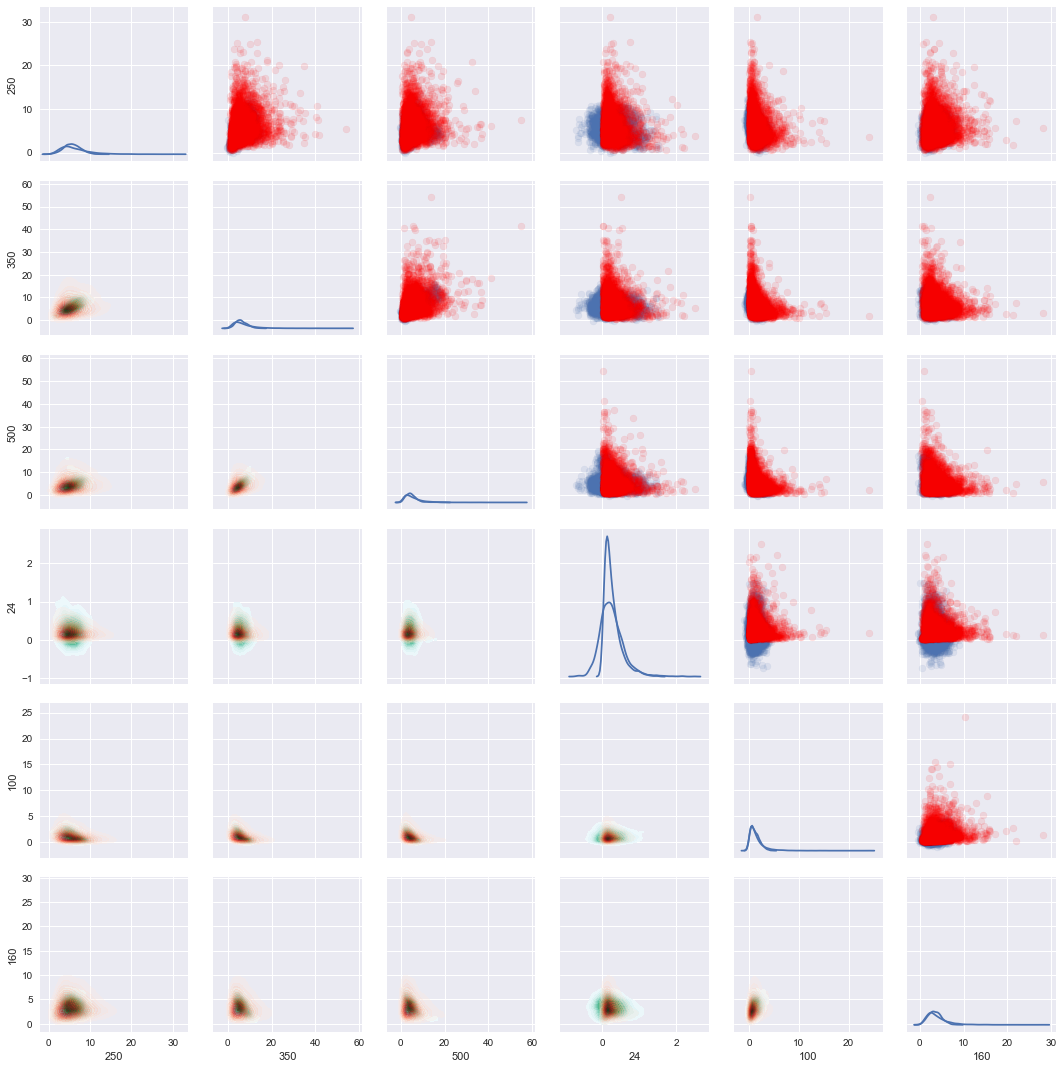

In [83]:
import seaborn as sns
import pylab as plt
%matplotlib inline
g=sns.PairGrid(df)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot,n_levels=20, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, alpha=0.1)
g.data=pd.DataFrame(np.power(10.0,log_normal),columns=['250','350','500','24', '100', '160'])
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot,n_levels=20, shade=True,shade_lowest=False, cmap="Reds", alpha=0.3)
g.map_upper(plt.scatter, alpha=0.1, color='r')

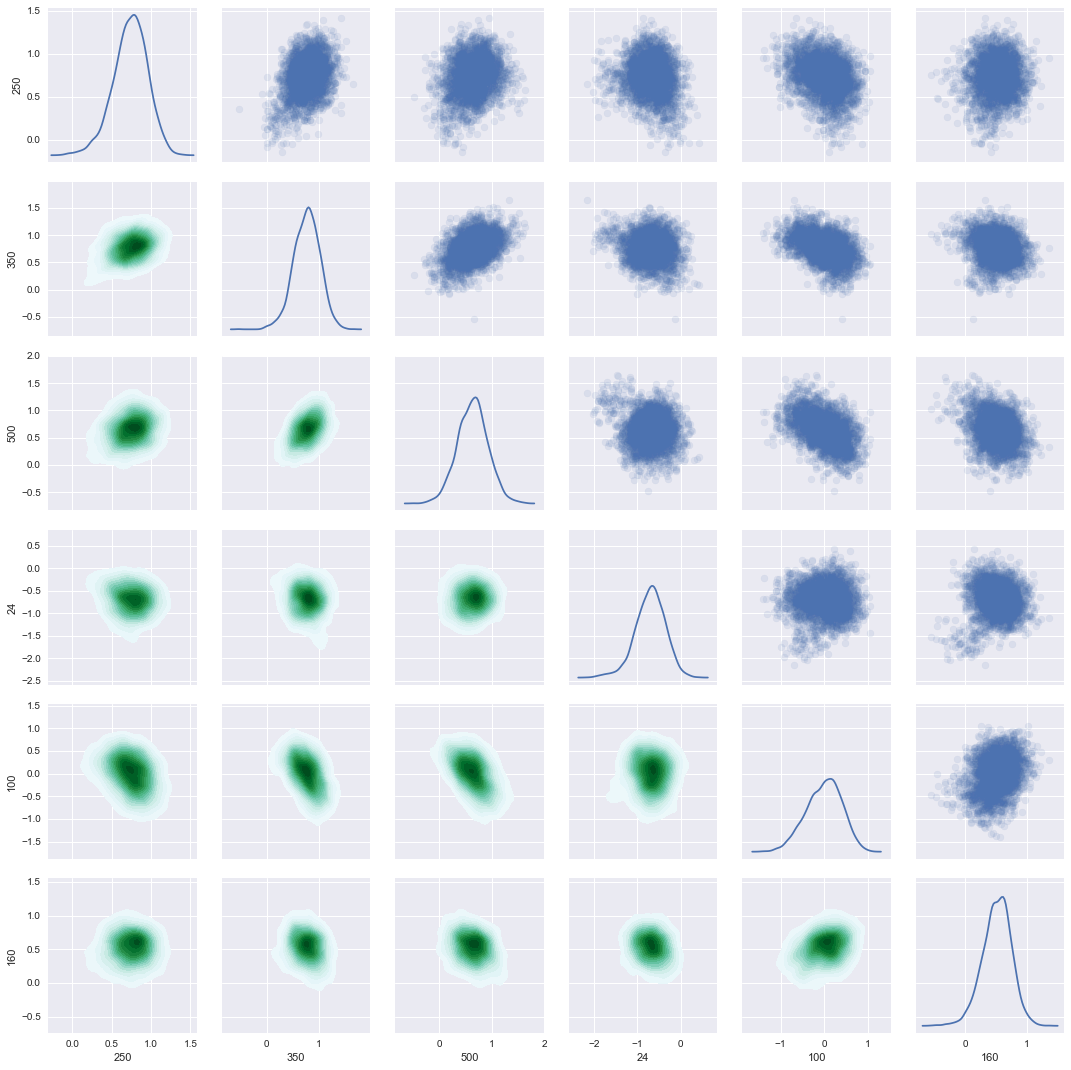

In [64]:
g=sns.PairGrid(pd.DataFrame(log_normal,columns=['250','350','500','24', '100', '160']))
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot,n_levels=20, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, alpha=0.1)

In [50]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices                                           


array([[0, 1, 2],
       [1, 0, 2],
       [2, 1, 0],
       [3, 4, 5],
       [4, 3, 5],
       [5, 4, 3]])

In [28]:
SEDs.shape

(32, 6, 800)

In [51]:
sig=np.empty((SEDs.shape[0],SEDs.shape[2]))
for i in range(0,SEDs.shape[2]):
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(SEDs[:,:,i])
    distances, indices = nbrs.kneighbors(SEDs[:,:,i])
    sig[:,i]=distances[:,1]

In [ ]:
for i in range(0,SEDs.shape[2]):
    sig[:,i]=

In [54]:
LIR=8
sig[0,:]*np.power(10.0,10)

array([  2.84348739e+10,   2.89852761e+02,   7.39912471e+01,
         3.28076832e+01,   1.84215686e+01,   1.18328268e+01,
         8.27184419e+00,   6.08707386e+00,   4.64899418e+00,
         3.66615825e+00,   2.96778394e+00,   2.45399866e+00,
         2.05449490e+00,   1.74368629e+00,   1.50220233e+00,
         1.31623894e+00,   1.16295300e+00,   1.03081403e+00,
         9.17509676e-01,   8.22262017e-01,   7.40674759e-01,
         6.70752248e-01,   6.11260293e-01,   5.61158752e-01,
         5.15448571e-01,   4.74220188e-01,   4.37594705e-01,
         4.05656978e-01,   3.77708809e-01,   3.52824123e-01,
         3.30828331e-01,   3.10742355e-01,   2.92361705e-01,
         2.74746025e-01,   2.58322317e-01,   2.43058547e-01,
         2.29758060e-01,   2.17732475e-01,   2.06540620e-01,
         1.95669097e-01,   1.85435595e-01,   1.76616959e-01,
         1.68405149e-01,   1.60811937e-01,   1.53362109e-01,
         1.46320176e-01,   1.39890665e-01,   1.34135236e-01,
         1.29036046e-01,

In [79]:
sig=np.empty((SEDs.shape[1],SEDs.shape[2]))
for i in range(0,SEDs.shape[2]):
    sig[:,i]=0.3*np.std(np.log10(SEDs[:,:,i]*10.0**LIR),axis=0)

In [70]:
np.save('log10_SED_IR_sig', sig)

In [12]:
np.trapz(df['Blue_SF_glx.norm_LIR'][(df['wave']>8) & (df['wave']<1000)][::-1],x=3.0E8/(df['wave'][(df['wave']>8) & (df['wave']<1000)][::-1]*1E-6))*1E-26/1E4

3.82580418875477e+29

In [13]:
df['wave']

0           0.009100
1           0.009400
2           0.009600
3           0.009800
4           0.010000
5           0.010200
6           0.010400
7           0.010600
8           0.010800
9           0.011000
10          0.011400
11          0.011800
12          0.012100
13          0.012500
14          0.012700
15          0.012800
16          0.013100
17          0.013200
18          0.013400
19          0.013700
20          0.014000
21          0.014300
22          0.014700
23          0.015100
24          0.015500
25          0.015900
26          0.016200
27          0.016600
28          0.017000
29          0.017300
            ...     
10975    1658.999475
10976    1669.000456
10977    1679.000889
10978    1689.000047
10979    1699.000924
10980    1708.999095
10981    1718.999480
10982    1728.999534
10983    1739.000479
10984    1748.999742
10985    1759.000491
10986    1769.000155
10987    1779.000020
10988    1788.999448
10989    1798.999774
10990    1809.000387
10991    1819

In [14]:
template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[0])

In [25]:
np.trapz(template['col2'][(template['col1']>8E3) & (template['col1']<1E6)],x=template['col1'][(template['col1']>8E3) & (template['col1']<1E6)])

0.99065289555174796

In [23]:
template['col1']

<Column name='col1' dtype='float64' length=11005>
     90.99999
         94.0
     95.99999
         98.0
        100.0
    102.00001
        104.0
    105.99997
    107.99998
    109.99997
    113.99998
        118.0
          ...
18389997.9277
18489994.3743
18590003.8614
18690000.2133
18789998.0454
18889991.6412
18989996.1042
19090005.9874
19189994.7448
19289998.9015
 19389991.964
19489989.7706

In [29]:
print(np.trapz(template['col2'][(template['col1']<8E3)],x=template['col1'][(template['col1']<8E3)]))
print(np.trapz(template['col2'][(template['col1']>8E3) & (template['col1']<1E6)],x=template['col1'][(template['col1']>8E3) & (template['col1']<1E6)]))
print(np.trapz(template['col2'][(template['col1']<1E6)],x=template['col1'][(template['col1']<1E6)]))


0.210849971767
0.990652895552
1.20152082665


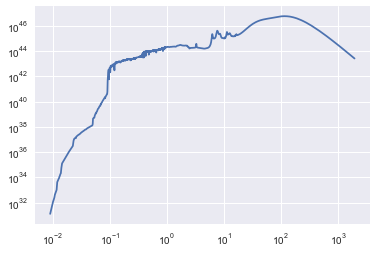

In [17]:
plt.loglog(df['wave'],df['Blue_SF_glx.norm_LIR'])

In [27]:
print(np.trapz(df['Blue_SF_glx.norm_LIR'][(df['wave']>8) & (df['wave']<1000)][::-1]
         ,x=3.0E8/(df['wave'][(df['wave']>8) & (df['wave']<1000)][::-1]*1E-6))*1E-26/1E4)
print(np.trapz(df['Blue_SF_glx.norm_LIR'][(df['wave']<8)][::-1]
         ,x=3.0E8/(df['wave'][(df['wave']<8)][::-1]*1E-6))*1E-26/1E4)

3.82580418875e+29
1.7493619078e+29


2.1954022988505746

## Test stan script

In [86]:
code="""
functions {
int intFloor(int leftStart, int rightStart, real iReal)
{
  // This is absurd. Use bisection algorithm to find int floor.
  int left;
  int right;

  left <- leftStart;
  right <- rightStart;

  while((left + 1) < right) {
    int mid;
    // print("left, right, mid, i, ", left, ", ", right, ", ", mid, ", ", iReal);
    mid <- left + (right - left) / 2;
    if(iReal < mid) {
      right <- mid;
    }
    else {
      left <- mid;
    }
  }
  return left;
}

// Interpolate arr using a non-integral index i
// Note: 1 <= i <= length(arr)
real interpolateLinear(real[] arr, real i)
{
  int iLeft;
  real valLeft;
  int iRight;
  real valRight;

  // print("interpolating ", i);

  // Get i, value at left. If exact time match, then return value.
  iLeft <- intFloor(1, size(arr), i);
  valLeft <- arr[iLeft];
  if(iLeft == i) {
    return valLeft;
  }

  // Get i, value at right.
  iRight <- iLeft + 1;
  valRight <- arr[iRight];

  // Linearly interpolate between values at left and right.
  print(valLeft + (valRight - valLeft) * (i - iLeft));
  return valLeft + (valRight - valLeft) * (i - iLeft);
}
}
data {
  int<lower=0> nsrc;//number of sources

  // ----SED templates----
  int nTemp;
  int nz;
  int nband;
  real SEDs[nTemp,nband,nz];
  vector[nband] flux[nsrc];//vector of source src_fes
  vector[nband] flux_sig[nsrc];//vector of source src_fes
}

parameters {
  vector<lower=5, upper=14>[nTemp] Nbb[nsrc];
  real<lower=0.001,upper=8> z[nsrc];

}
transformed parameters{
  vector[nband] src_f[nsrc];//vector of source src_fes


  for (i in 1:nsrc){
vector[nTemp] f_tmp[nband];
    for (b in 1:nband){
        for (t in 1:nTemp){

            f_tmp[b,t]=log10(Nbb[i,t]+interpolateLinear(SEDs[t,b], z[i]*1000.0));

        }
        src_f[i,b]=sum(f_tmp[b]);

    }
}

}
model {
for (s in 1:nsrc){
flux[s] ~ normal(src_f[s],flux_sig[s]);
}
}
"""

In [16]:
import pystan

In [49]:
flux=np.sum(SEDs_comb[:,:,3000].T*10.0**np.array([12,11,11,9]),axis=1)+np.random.normal(0,[1,1,1,0.02,0.5,0.5])


In [50]:
flux

array([ 2.80180271,  3.14830712,  4.99304504,  0.00677361,  0.72103822,
        0.41795028])

In [87]:
data={  
    'nsrc':1,
    'nTemp':SEDs_comb.shape[0],
    'nz':SEDs_comb.shape[2],
    'nband':6,
    'SEDs':SEDs_comb,
    'flux':flux[np.newaxis],
    'flux_sig':np.array([[1,1,1,0.2,0.5,0.5]])}

In [88]:
sm=pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aa797e4b6080b4b9bbdf06f49392a718 NOW.


In [92]:
fit_IR_combSED=sm.sampling(data=data,verbose=True, iter=1000,chains=1,seed=194838)

In [90]:
fit_IR_combSED

Inference for Stan model: anon_model_aa797e4b6080b4b9bbdf06f49392a718.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Nbb[0,0]     9.34    0.11   2.37   5.25   7.22   9.47  11.69  12.83    452    1.0
Nbb[0,1]     9.96    0.12   2.44   5.32   7.85  10.63  12.24  12.84    391    1.0
Nbb[0,2]    10.85    0.15   2.51    5.4   8.99  12.36  12.79  13.05    288    1.0
Nbb[0,3]     8.74    0.09   2.15   5.18   6.87   8.72  10.64  12.19    594    1.0
z[0]         5.49    0.09   1.55   2.48   4.31   5.58   6.79    7.9    276    1.0
src_f[0,0]   1.76    0.02   0.58    0.7   1.37   1.75   2.12   2.99    999    1.0
src_f[0,1]   3.35    0.02   0.75   1.82   2.84   3.39   3.87    4.8    964    1.0
src_f[0,2]    4.8    0.03   0.97   2.98   4.11   4.82   5.45    6.7   1215    1.0
src_f[0,3]   0.02  1.6e-3   0.03 8.7e-4 3.4e-3 6.7e-3   0.02   0.12    443 

In [54]:
SEDs_com

NameError: name 'SEDs_com' is not defined

In [91]:
import xidplus.stan_fit.stan_utility as stan_utility
stan_utility.check_treedepth(fit_IR_combSED)
stan_utility.check_energy(fit_IR_combSED)
stan_utility.check_div(fit_IR_combSED)

0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
3.0 of 2000 iterations ended with a divergence (0.15%)
Try running with larger adapt_delta to remove the divergences


In [56]:
samples=fit_IR_combSED.extract()

In [57]:
nondiv_params, div_params = stan_utility.partition_div(fit_IR_combSED)


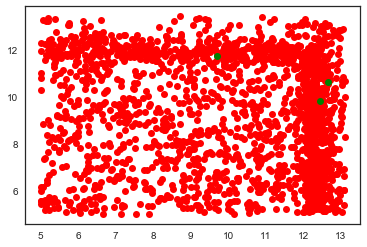

In [58]:
plt.plot(nondiv_params['Nbb'][:,1],nondiv_params['Nbb'][:,0], 'ro')
plt.plot(div_params['Nbb'][:,1],div_params['Nbb'][:,0], 'go')


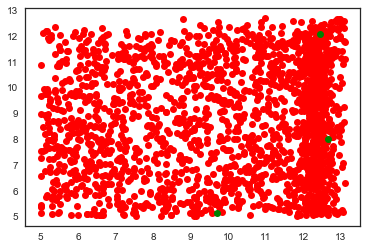

In [59]:
plt.plot(nondiv_params['Nbb'][:,1],nondiv_params['Nbb'][:,3], 'ro')
plt.plot(div_params['Nbb'][:,1],div_params['Nbb'][:,3], 'go')

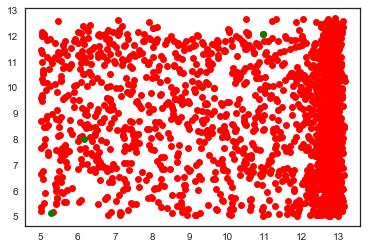

In [60]:
plt.plot(nondiv_params['Nbb'][:,2],nondiv_params['Nbb'][:,3], 'ro')
plt.plot(div_params['Nbb'][:,2],div_params['Nbb'][:,3], 'go')

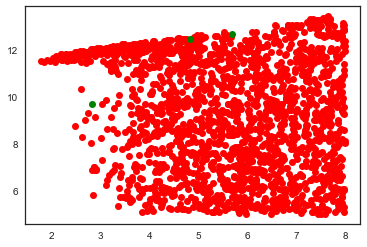

In [61]:
plt.plot(nondiv_params['z'][:],nondiv_params['Nbb'][:,0], 'ro')
plt.plot(div_params['z'][:],div_params['Nbb'][:,1], 'go')

NameError: name 'x' is not defined

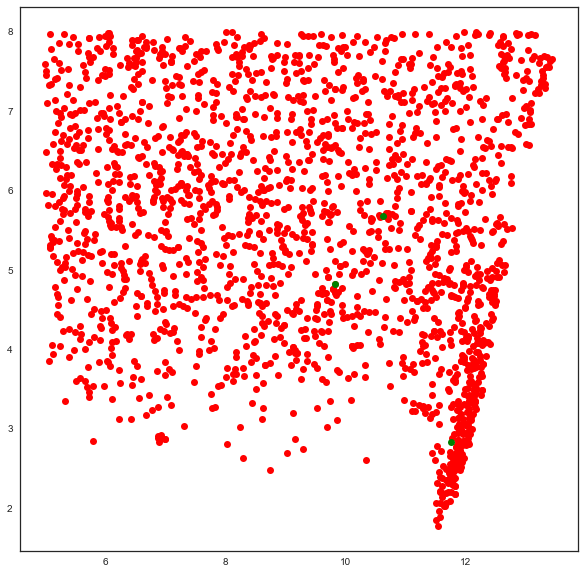

In [62]:
plt.figure(figsize=(10,10))
plt.plot(nondiv_params['Nbb'][:,0],nondiv_params['z'], 'ro')
plt.plot(div_params['Nbb'][:,0],div_params['z'], 'go')
plt.plot(x,y,'bo', alpha=0.2)


In [302]:
div_params['Nbb'].shape

(108, 4)

In [303]:
red[2000]

2.0

In [304]:
SEDs_comb.shape

(4, 6, 8000)

In [135]:
x,y=np.meshgrid(np.arange(11.8,12.5, 0.1), red)

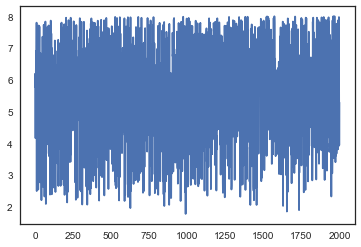

In [63]:
plt.plot(samples['z'])

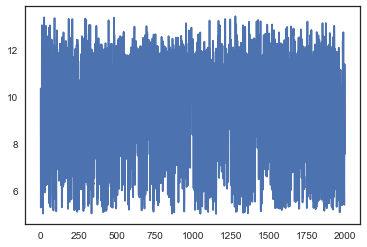

In [64]:
plt.plot(samples['Nbb'][:,0,0])

In [65]:
div_z=[]
for z in div_params['z']:
    div_z.append(np.abs(red-z).min())
nondiv_z=[]
for z in nondiv_params['z']:
    nondiv_z.append(np.abs(red-z).min())

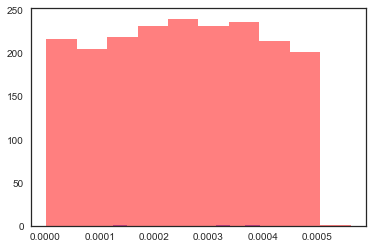

In [66]:
plt.hist(div_z,color='b', alpha=0.5);
plt.hist(nondiv_z,color='r', alpha=0.5);

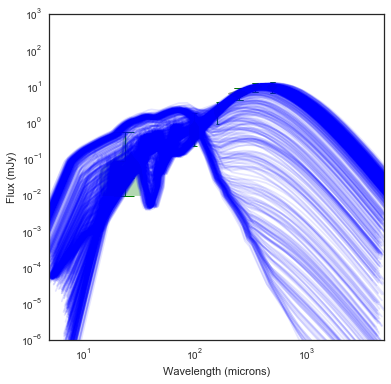

In [48]:
import seaborn as sns
sns.set_style("white")
b=0
plt.figure(figsize=(6,6))
s1=0
from astropy.cosmology import Planck13
violin_parts=plt.violinplot(samples['src_f'][:,s1,0:3],[250,350,500], points=60, widths=100,
                      showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('purple')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('purple')

violin_parts=plt.violinplot(samples['src_f'][:,s1,0:3],[250,350,500], points=60, widths=100,
                      showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('green')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('green')

violin_parts=plt.violinplot(samples['src_f'][:,s1,3:6],[24,100,160], points=60, widths=20,showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('green')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('green')
    
for s in np.arange(0,1000,1):
    z= samples['z'][s]
    div=(4.0*np.pi * np.square(Planck13.luminosity_distance(z).cgs))
    div=div.value
    tot_sed=np.power(10.0,samples['Nbb'][s,s1,0])*(1.0+z)*df_comb[str(b)]/div
    for b in range(1,4):
        tot_sed+=np.power(10.0,samples['Nbb'][s,s1,b])*(1.0+z)*df_comb[str(b)]/div
    plt.loglog((z+1.0)*df_comb['wave'],tot_sed, 'b', alpha=0.1)
plt.ylim(10E-7,10E2)
plt.xlim(5,5E3)
#plt.plot([3.6,4.5,5.7,7.9],[2.91E-3,2.38E-3,2.12E-3,9.6E-3], 'ro')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (mJy)')

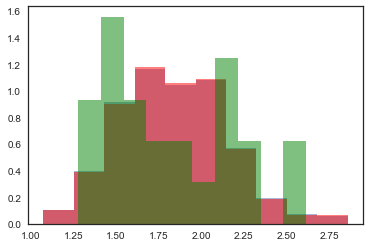

In [246]:
b=5
plt.hist(samples['src_f'][:,0,b], alpha=0.5,normed=True);
plt.hist(nondiv_params['src_f'][:,b], color='red', alpha=0.5,normed=True);
plt.hist(div_params['src_f'][:,b], color='green', alpha=0.5,normed=True);


In [213]:
samples['z'].shape

(1000,)

## why/where am I getting divergent transitions?
Its not obvious any parameters are causing the problem.

They do not occur at any particular likelihood value

Is it the grid causing issue?
Is it the uniform prior?

NameError: name 'diverg' is not defined

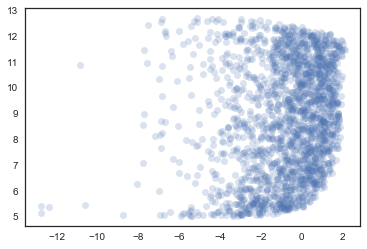

In [67]:
plt.plot(samples['lp__'],samples['Nbb'][:,0,3], 'o',alpha=0.2)
plt.plot(samples['lp__'][diverg],samples['Nbb'][diverg,0,3], 'ro',alpha=0.2)


In [79]:
diverg=fit_IR_combSED.get_sampler_params()[0]['divergent__']==1.0

In [327]:
samples['Nbb'].shape

(1000, 1, 4)

In [80]:
np.arange(0,1000)[diverg]

array([  1,   2,   3,   4,  62,  91, 100, 101, 123, 129, 151, 188, 192,
       224, 251, 425, 451])

In [85]:
samples['z'][424:427]

array([ 7.31326683,  2.97283728,  4.12264925])

## GP alternative

In [93]:
GPcode="""functions {
  vector gp_pred_rng(real[] x2,
                     vector y1, real[] x1,
                     real alpha, real rho, real sigma, real delta) {
    int N1 = rows(y1);
    int N2 = size(x2);
    vector[N2] f2;
    {
      matrix[N1, N1] K =   cov_exp_quad(x1, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N1));
      matrix[N1, N1] L_K = cholesky_decompose(K);

      vector[N1] L_K_div_y1 = mdivide_left_tri_low(L_K, y1);
      vector[N1] K_div_y1 = mdivide_right_tri_low(L_K_div_y1', L_K)';
      matrix[N1, N2] k_x1_x2 = cov_exp_quad(x1, x2, alpha, rho);
      vector[N2] f2_mu = (k_x1_x2' * K_div_y1);
      matrix[N1, N2] v_pred = mdivide_left_tri_low(L_K, k_x1_x2);
      matrix[N2, N2] cov_f2 =   cov_exp_quad(x2, alpha, rho) - v_pred' * v_pred
                              + diag_matrix(rep_vector(delta, N2));
      f2 = multi_normal_rng(f2_mu, cov_f2);
    }
    return f2;
  }
}

data {
  int<lower=1> N;
  real x[N];
  vector[N] y;

  int<lower=1> N_predict;
  real x_predict[N_predict];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N_predict] f_predict = gp_pred_rng(x_predict, y, x, alpha, rho, sigma, 1e-10);
  vector[N_predict] y_predict;

  for (n in 1:N_predict)
    y_predict[n] = normal_rng(f_predict[n], sigma);
}
"""

In [94]:
sm=pystan.StanModel(model_code=GPcode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66d2b322c018ce81f1c399f4e91c226b NOW.


In [96]:
data={
    'N':SEDs_comb.shape[2],
    'x':red,
    'y':SEDs_comb[0,0,:],
    'N_predict':1,
    'x_predict':[3.2],
    'rho':0.1,
    'alpha':1,
    'sigma':0.1
}

In [95]:
SEDs_comb.shape

(4, 6, 8000)

In [ ]:
GP=sm.sampling(data=data,verbose=True, iter=1000,chains=1,seed=194838,algorithm="Fixed_param")

Thinking and what to do in 2018:
* First try log10 space for the SED_comb run. This may help divergence transitions
* Try interpolation via GPs

